In [1]:
import numpy as np
from neuralStellar2 import NNmodel,Teff2colour
import pymc3 as pm
import theano.tensor as T
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def plotCluster(df):
    fig, ax=plt.subplots(1,1, figsize=(10,10))
    ax.scatter(df['Bp_Rp'], df['g_mag'], s=15, zorder=3, c='blue', label='members')
    ax.set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
    ax.set_ylabel('apparent G (mag)')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.legend()
    ax.grid()
    plt.show()

Loading in the NN models, m1 = stellar evolution NN, t1 = Teff to colour NN

In [3]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'],Teff_scaling=5000)
m1.loadModel('Ran_files/big_grid_146(h)/000_best_model.h5', summary=False)
m1.getWeights()

t1=Teff2colour(['log_Teff','logg','[Fe/H]','Av'],['Bessell_U','Bessell_B','Bessell_V','Bessell_R','Bessell_I','Gaia_G_MAW','Gaia_BP_MAWb','Gaia_BP_MAWf','Gaia_RP_MAW'])
t1.loadModel('Post-handin/test6.h5', summary=False)
t1.getWeights()

Creating the cluster

In [6]:
N=20
[Av, dist_mod] = [0.160758, 9.660732908839677]
#[Av, dist_mod] = [0, 9.660732908839677]
Mbol = 4.75

#fundamentals
Tmass = np.random.rand(N)*(1.44-0.84)+0.84
Tage = np.random.randn(N)*0.1+3.52
Tfeh = np.random.randn(N)*0.05+0.1
TY = np.random.randn(N)*0.01+0.255
TMLT = np.ones(N)*2.1

T_in1 = np.log10([Tmass, Tage, 10**Tfeh, TY, TMLT]).T
T_out1 = m1.model.predict(T_in1).T

#observables
TTeff = 10**T_out1[1,:]*5000
Tradius = 10**T_out1[0,:]
TL = Tradius**2*(TTeff/5776.02970722)**4
Tlogg = np.log10(100*6.67408e-11*(Tmass/Tradius**2)*(1.98e30/6.96e8**2))
TAv = np.ones(N)*Av

T_in2 = np.array([np.log10(TTeff),Tlogg,Tfeh,TAv]).T
T_out2 = t1.model.predict(T_in2).T

TBCg = T_out2[5,:]
TBCbp = T_out2[7,:]
TBCrp = T_out2[8,:]

#apparent mag and colour
TmG = -2.5*np.log10(TL)-TBCg+Mbol+dist_mod
TBp_Rp = TBCrp-TBCbp

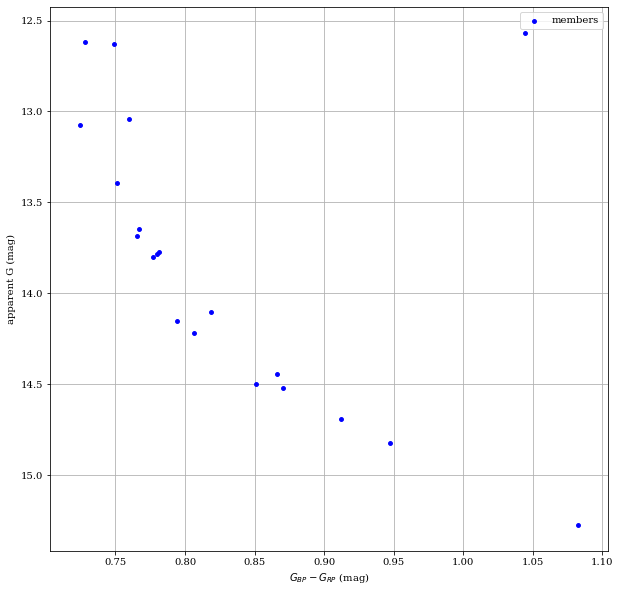

In [7]:
NNdf = pd.DataFrame({'mass':Tmass,'age':Tage,'feh':Tfeh,'Y':TY,'MLT':TMLT,
                     'Teff':TTeff,'radius':Tradius,'luminosity':TL,'logg':Tlogg,'Av':TAv,
                     'BCg':TBCg,'BCbp':TBCbp,'BCrp':TBCrp,'g_mag':TmG,'Bp_Rp':TBp_Rp,'g_mag_err':np.ones(N)*0.01,'Bp_Rp_err':np.ones(N)*0.015})
plotCluster(NNdf)

In [8]:
old1 = pd.read_csv('data_collection/NGC_2682/NGC_2682_cut.csv')
old2 = pd.read_csv('data_collection/NGC_2682/stars_results.csv')
old = old1.merge(old2,on='ID')
old['Av'] = np.ones(len(old.index))*Av
old['radius_sq'] = old['true_L_est']*(5776.02970722/old['Teff'])**4
old['logg'] = np.log10(100*6.67408e-11*(old['mass_est']/old['radius_sq'])*(1.98e30/6.96e8**2))
old['log_Teff'] = np.log10(old['Teff'])
y_out = t1.model.predict(old[['log_Teff','logg','feh_est','Av']],verbose=2).T

old['g_mag'] = -2.5*np.log10(old['true_L_est'])-y_out[5]+Mbol+dist_mod
old['Bp_Rp'] = y_out[8]-y_out[7]

106/106 - 0s


Plotting the pseudo cluster with M67 to show they all overlap in the HR diagram
labels: members = NN pseudo cluster
M67 = Gaia data
old = magnitudes and colours calculated from Teff and luminosity collected previously in the project

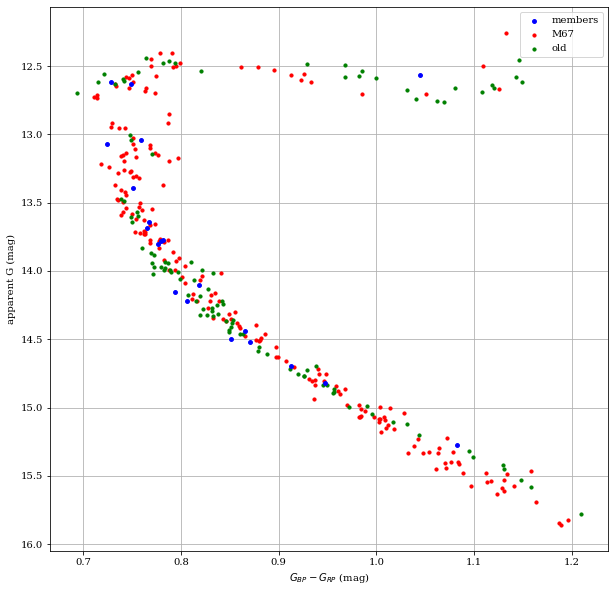

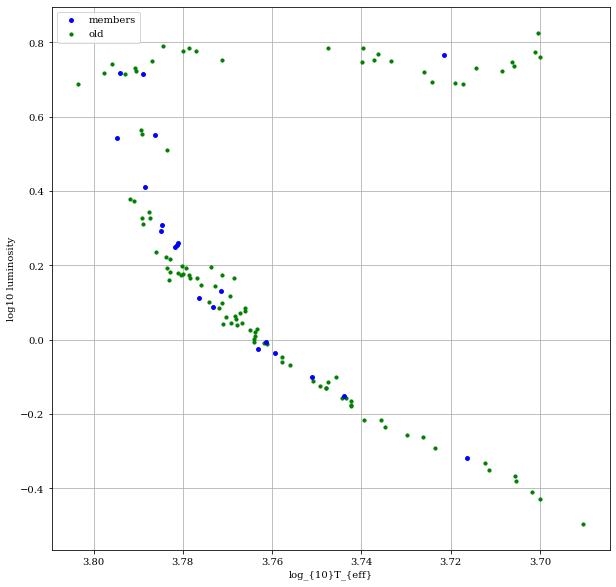

In [9]:
M67 = pd.read_csv('data_collection/NGC_2682/NGC_2682_post_samples2.csv')
fig, ax=plt.subplots(1,1, figsize=(10,10))
ax.scatter(NNdf['Bp_Rp'], NNdf['g_mag'], s=15, zorder=3, c='blue', label='members')
ax.scatter(M67['Bp_Rp'], M67['g_mag'], s=10, zorder=2, c='red', label='M67')
ax.scatter(old['Bp_Rp'], old['g_mag'], s=10, zorder=2, c='green', label='old')
ax.set_xlabel(r'$G_{BP}-G_{RP}$ (mag)')
ax.set_ylabel('apparent G (mag)')
ax.set_ylim(ax.get_ylim()[::-1])
ax.legend()
ax.grid()
plt.show()

In [10]:
model = pm.Model()
with model:
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',1.1,1.1)*2+2.5)
    Age_sigma = pm.Lognormal('spread_age',T.log(0.15),0.4)
    feh_mu = pm.Deterministic('mean_feh',pm.Beta('e',1.1,1.1)*0.4-0.2)
    feh_sigma = pm.Lognormal('spread_feh',T.log(0.05),0.5)
    Y_mu = pm.Deterministic('mean_Y',pm.Beta('f',1.1,1.1)*0.04+0.24)
    Y_sigma = pm.Lognormal('spread_Y',T.log(0.01),0.5)
    MLT_mu = pm.Deterministic('mean_MLT',pm.Beta('g',1.1,1.1)*0.6+1.7)
    
    M = pm.Deterministic('mass', pm.Beta('d',1.1,1.1,shape=N)*(1.5-0.8)+0.8)
    Age = pm.Deterministic('age',pm.Normal('age_normal', 0, 1, shape=N)*Age_sigma+Age_mu)
    feh = pm.Deterministic('feh',pm.Normal('feh_normal', 0, 1, shape=N)*feh_sigma+feh_mu)
    Y = pm.Deterministic('Y',pm.Normal('Y_normal', 0, 1, shape=N)*Y_sigma+Y_mu)
    MLT = pm.Deterministic('MLT',T.ones(N)*MLT_mu)
    
    #feh = T.ones(N)*0
    #Y = T.ones(N)*0.28
    #MLT = T.ones(N)*1.9
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    Teff = pm.Deterministic('Teff', 10**obs[1,:]*5000)
    radius = pm.Deterministic('radius', 10**obs[0,:])
    L = pm.Deterministic('L', radius**2*(Teff/5776.02970722)**4)
    logg = pm.Deterministic('logg', T.log10(100*6.67408e-11*(M/radius**2)*(1.98e30/6.96e8**2)))
    Av_list = pm.Deterministic('Av', T.ones(N)*Av)
    
    BCs = pm.Deterministic('BCs', t1.manualPredict(T.as_tensor_variable([T.log10(Teff), logg, feh, Av_list])))
    
    #BCg = pm.Bound(pm.Deterministic, lower=-8, upper=1)('BCg', BCs[5,:])
    BCg = pm.Deterministic('BCg', BCs[5,:])
    BCbp = pm.Deterministic('BCbp', BCs[7,:])
    BCrp = pm.Deterministic('BCrp', BCs[8,:])
    
    true_mG = pm.Deterministic('true_mG', -2.5*T.log10(L)-BCg+Mbol+dist_mod)
    true_Bp_Rp = pm.Deterministic('true_Bp_Rp', BCrp-BCbp)
    
    obs_mG = pm.Normal('obs_mG',true_mG,sigma=NNdf['g_mag_err'], observed=NNdf['g_mag'])
    obs_Bp_Rp = pm.Normal('obs_Bp_Rp',true_Bp_Rp,sigma=NNdf['Bp_Rp_err'], observed=NNdf['Bp_Rp'])

In [11]:
start = {'mean_age':3.5, 'spread_age':0.1, 'mean_feh':0.1, 'spread_feh':0.05, 'mean_Y':0.26, 'spread_Y':0.01, 'mean_MLT':2.0}
with model:
    trace = pm.sample(500,tune=100, init='adapt_diag', start=start, target_accept=0.999, cores=2, chains=2)

#pm.save_trace(trace, directory='M67_trace1', overwrite=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Y_normal, feh_normal, age_normal, d, g, spread_Y, f, spread_feh, e, spread_age, a]


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [12]:
summary = pm.summary(trace, var_names=['mean_age','spread_age','mean_feh','spread_feh','mean_Y','spread_Y','mean_MLT'])
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,3.380,0.136,3.122,3.621,0.066,0.050,4.0,4.0,4.0,24.0,1.43
spread_age,0.151,0.051,0.052,0.238,0.014,0.010,13.0,13.0,12.0,61.0,1.12
mean_feh,0.090,0.029,0.033,0.139,0.007,0.005,18.0,17.0,18.0,88.0,1.11
spread_feh,0.041,0.013,0.019,0.067,0.004,0.003,12.0,12.0,10.0,192.0,1.14
mean_Y,0.261,0.010,0.245,0.277,0.004,0.003,5.0,5.0,5.0,22.0,1.33
spread_Y,0.010,0.004,0.004,0.018,0.001,0.000,54.0,54.0,53.0,94.0,1.04
mean_MLT,1.980,0.111,1.763,2.170,0.051,0.038,5.0,5.0,5.0,26.0,1.33


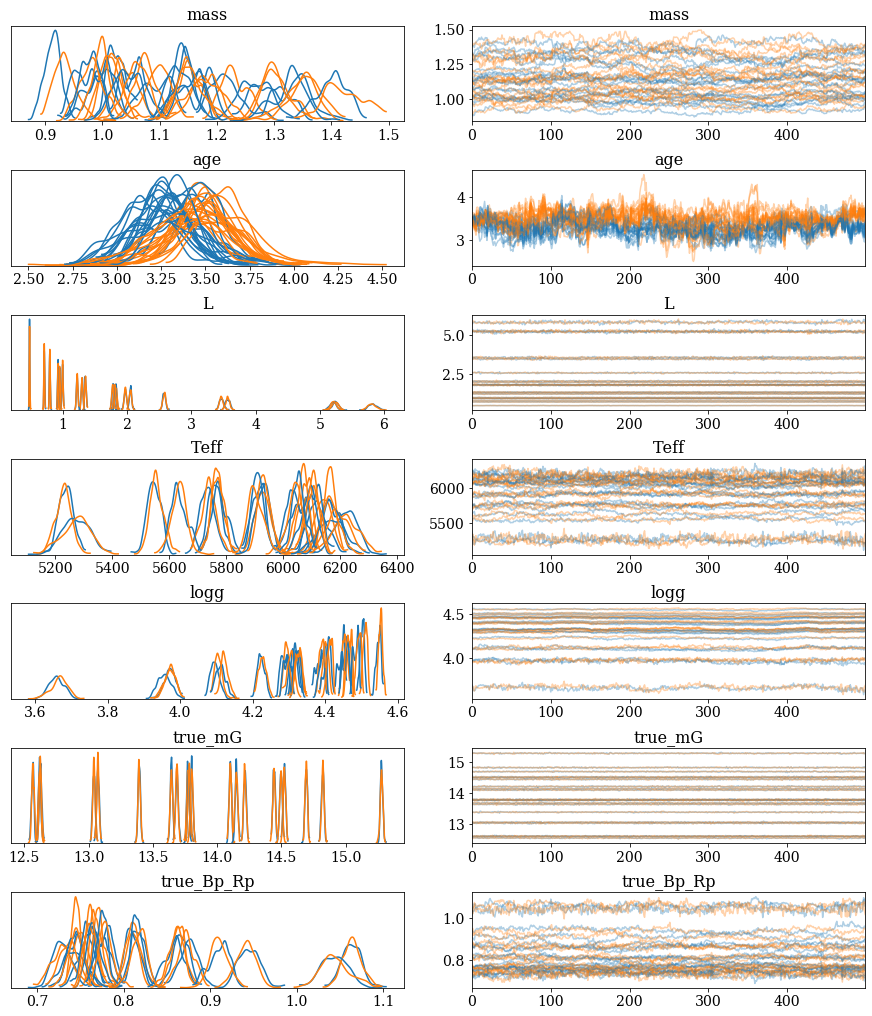

In [13]:
pm.plots.traceplot(trace,var_names=['mass','age',
                                    'L','Teff','logg',
                                    'true_mG','true_Bp_Rp'],compact=True)
plt.show()

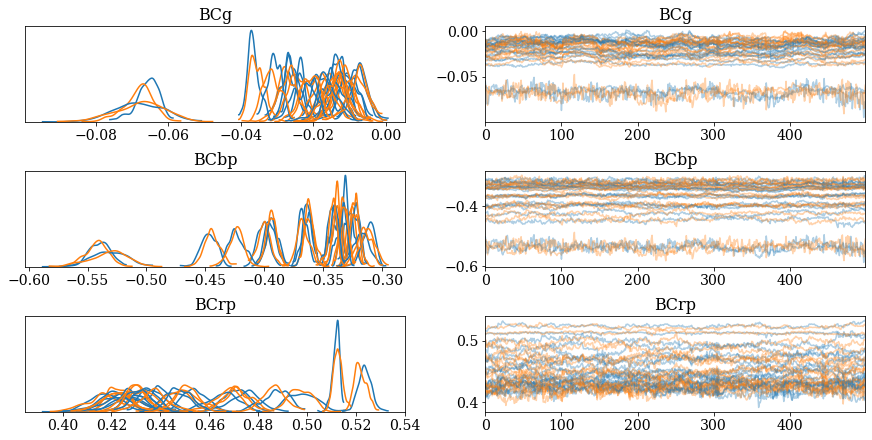

In [14]:
pm.plots.traceplot(trace,var_names=['BCg','BCbp','BCrp'],compact=True)
plt.show()